# Práctico Análisis Exploratorio y Curación de Datos

In [43]:
from IPython.display import display, Markdown

def display_markdown(*args, **kwargs):
    return display(Markdown(*args, **kwargs))

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from hashlib import md5

import sys
if 'ftfy' not in sys.modules:
    !pip install 'ftfy<5.6'
import ftfy.badness as bad

!pip install feedparser
import feedparser

pd.options.display.float_format = '{:.2f}'.format

BLUE = '#35A7FF'

##  Ingesta de Datos

### Formatos de Datos - CSV

####  Ejercicio 1: Tablas de Crecimiento
1. Descargar dataset en CSV
[Tablas de Peso](https://github.com/DiploDatos/AnalisisYCuracion/blob/master/input/wtageinf.csv)
Basado en material de https://www.cdc.gov/growthcharts/percentile_data_files.htm

2. Graficar las curvas correspondientes a cada percentil para niños y niñas
- En la columna Sex, 1 representa a niños y 2 a niñas
- Las curvas de los percentiles correspondientes a un mismo sexo deben ir en un mismo
gráfico.
- Un gráfico para cada sexo

In [44]:
# datasets
ds_tablas_peso = pd.read_csv("https://raw.githubusercontent.com/DiploDatos/AnalisisYCuracion/master/input/wtageinf.csv")
ds_tablas_peso_chicos = ds_tablas_peso[ds_tablas_peso['Sex'] == 1]
ds_tablas_peso_chicas = ds_tablas_peso[ds_tablas_peso['Sex'] == 2]

In [45]:
ds_tablas_peso.dtypes

Sex         int64
Agemos    float64
L         float64
M         float64
S         float64
P3        float64
P5        float64
P10       float64
P25       float64
P50       float64
P75       float64
P90       float64
P95       float64
P97       float64
dtype: object

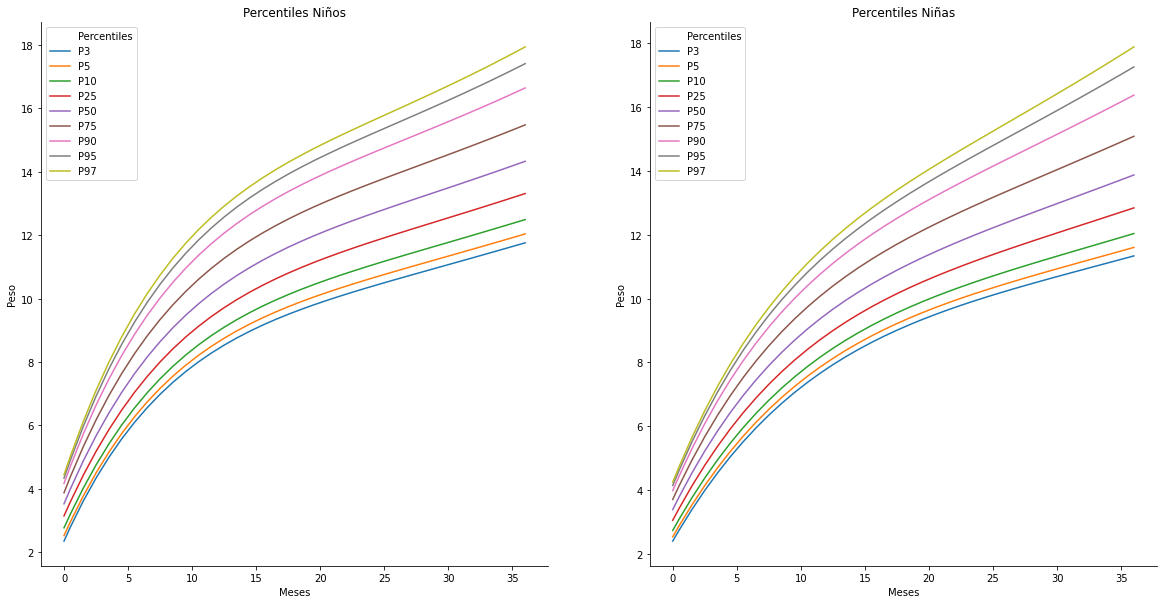

In [46]:
ds_tablas_peso_chicos_melt = ds_tablas_peso_chicos.melt('Agemos', var_name='Percentiles',  value_name='vals', value_vars=['P3', 'P5', 'P10', 'P25', 'P50', 'P75', 'P90', 'P95', 'P97'])
plt.figure(figsize=(20,10))
plt.subplot(121)
sbn.lineplot(data=ds_tablas_peso_chicos_melt, x='Agemos', y='vals', hue='Percentiles')
plt.xlabel('Meses')
plt.ylabel('Peso')
plt.title('Percentiles Niños')
sbn.despine()

ds_tablas_peso_chicas_melt = ds_tablas_peso_chicas.melt('Agemos', var_name='Percentiles',  value_name='vals', value_vars=['P3', 'P5', 'P10', 'P25', 'P50', 'P75', 'P90', 'P95', 'P97'])
plt.subplot(122)
sbn.lineplot(data=ds_tablas_peso_chicas_melt, x='Agemos', y='vals', hue='Percentiles')
plt.xlabel('Meses')
plt.ylabel('Peso')
plt.title('Percentiles Niñas')
sbn.despine()

### Formato de Datos - JSON

#### Ejercicio 2: Pasos Fronterizos

1. Descargar dataset en JSON: [Pasos Fronterizos](https://github.com/DiploDatos/AnalisisYCuracion/blob/master/input/pasos.json)
2. Graficar un gráfico de barras agrupando por valor del atributo “province”.

In [47]:
pasos_fronterizos = pd.read_json("https://raw.githubusercontent.com/DiploDatos/AnalisisYCuracion/master/input/pasos.json")

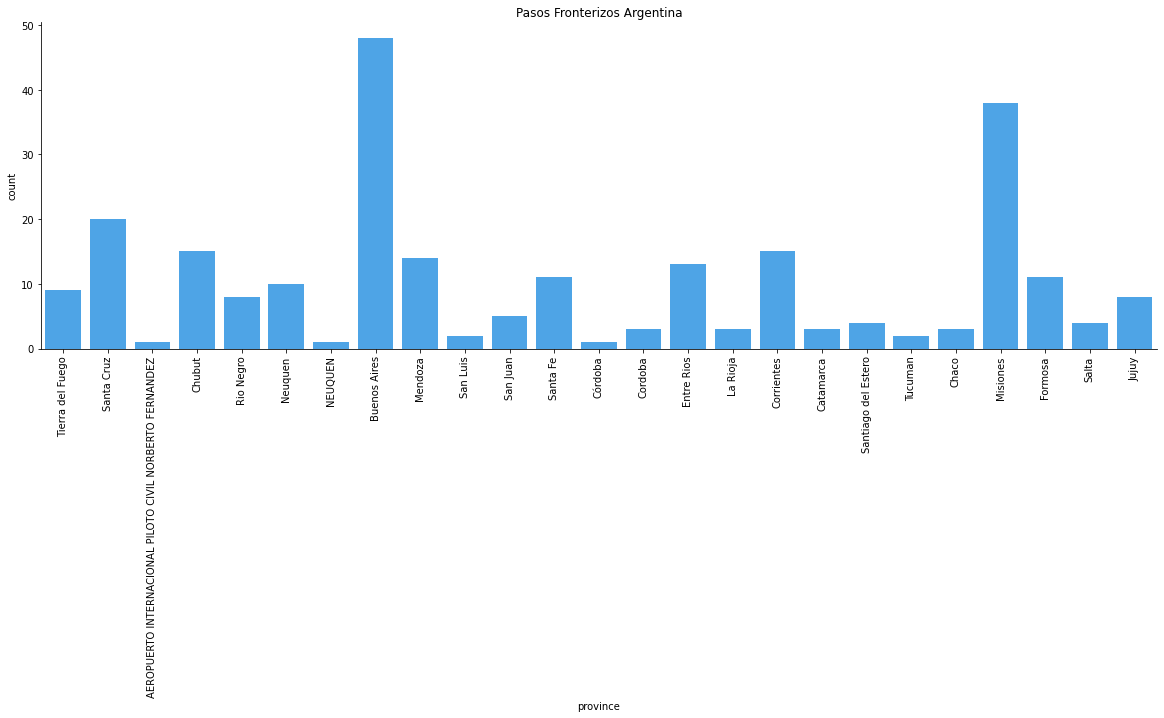

In [48]:
plt.figure(figsize=(20,6))
sbn.countplot(data=pasos_fronterizos, x='province', color=BLUE)
plt.xticks(rotation=90);
plt.title('Pasos Fronterizos Argentina')
sbn.despine()

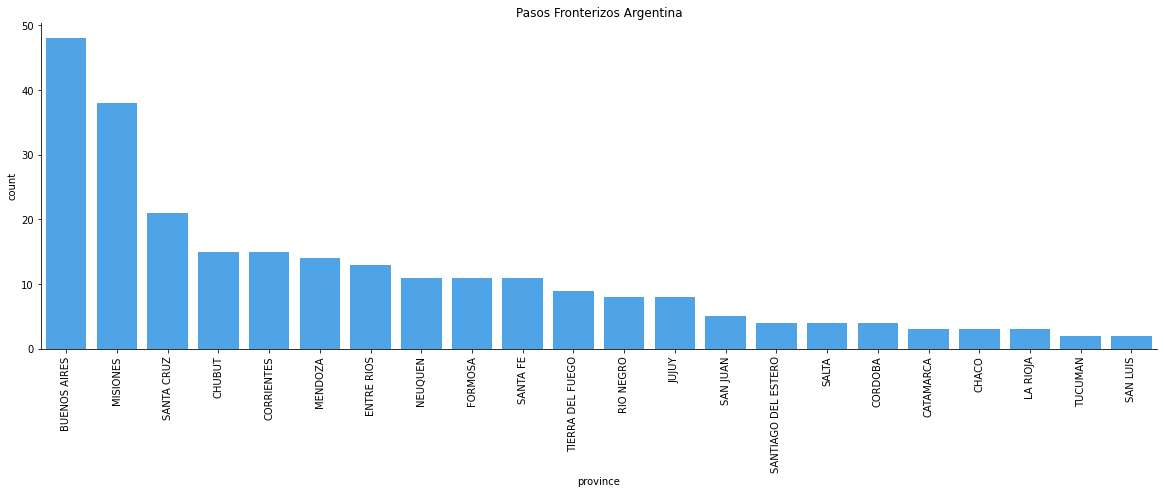

In [49]:
# Se eliminan acentos, ignoran mayusculas/minusculas y reubica el aeropuerto a Santa Cruz.

pasos_fronterizos['province'] = pasos_fronterizos['province'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
pasos_fronterizos["province"].replace({"AEROPUERTO INTERNACIONAL PILOTO CIVIL NORBERTO FERNANDEZ": "Santa Cruz"}, inplace=True)
pasos_fronterizos['province'] = pasos_fronterizos['province'].str.upper()

plt.figure(figsize=(20,6))
sbn.countplot(data=pasos_fronterizos, x='province', color=BLUE, order = pasos_fronterizos['province'].value_counts().index)
plt.xticks(rotation=90);
plt.title('Pasos Fronterizos Argentina')
sbn.despine()

### Representación de Datos - Grafos

- edgeList = [ [0, 2], [1, 3], [2, 3],
 [2, 4], [3, 5], [4, 5] ];
- adjMatrix = [...];
- adjList = [...];

In [50]:
def edgeListToAdjMaxix(edgeList):
    
    max_value = max(map(max, edgeList)) +1
    
    adjMatrix = np.zeros((max_value, max_value), dtype=int)
    
    for row in edgeList:
        adjMatrix[row[0]][row[1]] = 1
        
    table_names = np.arange(0, max_value)
    
    ds_adjMatrix = pd.DataFrame(data=adjMatrix,    # values
                    index=table_names,             # 1st column as index
                    columns=table_names)           # 1st row as the column names
    
    return ds_adjMatrix

In [51]:
edgeList = np.array([ [0, 2], [1, 3], [2, 3], [2, 4], [3, 5], [4, 5] ])
edgeListToAdjMaxix(edgeList)

,0,1,2,3,4,5
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,0,0,1,1,0
3,0,0,0,0,0,1
4,0,0,0,0,0,1
5,0,0,0,0,0,0


In [52]:
def edgeListToAdjList(edgeList, tipo='dirigido'):
    max_value = max(map(max, edgeList)) +1
    
    adjList = [ [] for _ in range(max_value) ]

    for row in edgeList:
        i = row[0]
        j = row[1]

        adjList[i].append(j)
        if tipo == 'no_dirigido' :
            adjList[j].append(i)

    return adjList

In [53]:
print('Dirigido: {}'.format(edgeListToAdjList(edgeList)))
print('Si fuera No Dirigido: {}'.format(edgeListToAdjList(edgeList, tipo='no_dirigido')))


Dirigido: [[2], [3], [3, 4], [5], [5], []]
Si fuera No Dirigido: [[2], [3], [0, 3, 4], [1, 2, 5], [2, 5], [3, 4]]


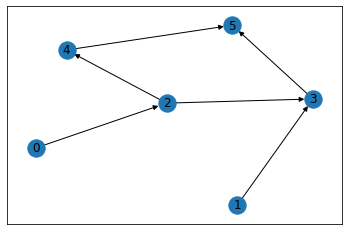

In [54]:
import networkx as nx
import numpy as np

edgeList = np.array([ [0, 2], [1, 3], [2, 3], [2, 4], [3, 5], [4, 5] ])
G = nx.DiGraph()
G.add_edges_from(edgeList)
# Plot it
nx.draw_networkx(G, arrows=True, with_labels=True)

### Limpieza de Datos

Realizar todos los ejercicios del notebook Limpieza.ipynb
Consideraciones para todos ejercicios:
- Los notebooks deben poder reproducirse
- Es decir, deben poder re-ejecutarse en un paso sin errores siguiendo las instrucciones
dadas
- Ej. En Limpieza.ipynb quiten las celdas que dan error y las que no son significativas
- Probar los ejercicios en un entorno limpio desde 0 antes de entregar.
- Seguir las propias instrucciones al detalle o mejor dar a un tercero y revisar

**Estos ejercicios se encuentran a continuación de los ejercicios de clase.**


### Ingestión de Datos - SQL
Descargar DB de ejemplo: 
- Canciones de Iron Maiden
- Discos con más de 25 canciones
- Las 10 canciones más populares
- Reescribir la siguiente consulta con JOIN

```sql
SELECT trackid, name
FROM tracks
WHERE albumid = (
 SELECT albumid
 FROM albums
 WHERE title = ‘Let There Be Rock’
);
```

**Canciones de Iron Maiden:**
```sql
SELECT
	TRA.NAME, ALB.TITLE, ART.NAME
FROM
	ARTISTS ART,
	ALBUMS ALB,
	TRACKS TRA
WHERE
	ART.ARTISTID = ALB.ARTISTID AND
	ALB.ALBUMID = TRA.ALBUMID AND
	ART.NAME = 'Iron Maiden';
```
**Discos con más de 25 canciones**

```sql
SELECT
    COUNT(TRA.NAME) AS COUNT_TRACKS, ALB.TITLE AS ALBUM, ART.NAME AS ARTISTA
FROM
    ARTISTS ART
    INNER JOIN ALBUMS ALB
    INNER JOIN TRACKS TRA
ON
    ART.ARTISTID = ALB.ARTISTID AND
    ALB.ALBUMID = TRA.ALBUMID
GROUP BY ALBUM
HAVING COUNT_TRACKS > 25
ORDER BY COUNT_TRACKS DESC;
```

**Las 10 canciones más populares (compradas)**

```sql
SELECT
	TRA.TRACKID, TRA.NAME AS CANCIONES, ALB.TITLE AS ALBUM, ART.NAME AS ARTISTA, INV.TRACKID, COUNT(INV.QUANTITY) AS COUNT_PURCHASES
FROM
	ARTISTS ART
	INNER JOIN ALBUMS ALB
	INNER JOIN TRACKS TRA
	INNER JOIN INVOICE_ITEMS INV
ON
	ART.ARTISTID = ALB.ARTISTID AND
	ALB.ALBUMID = TRA.ALBUMID AND
	TRA.TRACKID = INV.TRACKID
GROUP BY INV.TRACKID
ORDER BY COUNT_PURCHASES DESC
LIMIT 10;
```

**Las 10 canciones más populares (playlist)**

```sql
SELECT
	TRA.TRACKID, TRA.NAME AS CANCIONES, ALB.TITLE AS ALBUM, ART.NAME AS ARTISTA, COUNT(*) AS COUNT_PLAYLIST
FROM
	ARTISTS ART
	INNER JOIN ALBUMS ALB
	INNER JOIN TRACKS TRA
	INNER JOIN PLAYLIST_TRACK PLAY
ON
	ART.ARTISTID = ALB.ARTISTID AND
	ALB.ALBUMID = TRA.ALBUMID AND
	TRA.TRACKID = PLAY.TRACKID
GROUP BY PLAY.TRACKID
ORDER BY COUNT_PLAYLIST DESC
LIMIT 10;
```

**Reescribir la consulta con JOIN**
```sql
SELECT TRACKID, NAME
FROM TRACKS
	INNER JOIN ALBUMS
ON
	ALBUMS.ALBUMID = TRACKS.ALBUMID
WHERE
	TITLE = "Let There Be Rock";
```

### Ingestión de Datos - RSS
Descargar títulos de artículos de Tecnología de La Voz del Interior
- Ayuda 1 : https://www.lavoz.com.ar/rss/tecnologia.xml
- Ayuda 2: pip install feedparser
- Ayuda 3: https://github.com/playgrdstar/rss_ingestion/blob/master/RSS%20Ingestion.ipynb

In [55]:
feed = feedparser.parse('https://www.lavoz.com.ar/rss/tecnologia.xml')

display_markdown('### Títulos: La Voz - Tecnología')
for item in feed.entries:
    display_markdown('- {}'.format(item.title))

### Títulos: La Voz - Tecnología

- Fifa 21 trae novedades en el modo carrera, un gameplay más realista, y nuevas formas de jugar online en equipo

- Ya se puede retransmitir en directo en Facebook desde las salas de Messenger

- Twitter tuvo un primer semestre para el olvido: perdió U$S 1.236 millones

- Twitter: hackers accedieron a mensajes privados de 36 de las 130 cuentas afectadas por el ataque a la plataforma

- Google pospone a marzo de 2021 la indexación de las páginas web y le da prioridad a su versión móvil

- Nuevas medidas de seguridad para Facebook Messenger: mensajes privados con autenticación biométrica

- Lenovo presenta su primer smartphone gaming: Legion Phone Duel, optimizado para jugar en horizontal

- Gmail verificará la identidad de las empresas con un logo para evitar correos maliciosos

- Sólo Facebook sabe qué es lo más popular en su red social

- Día del Amigo: las videollamadas por Whatsapp crecieron 500% este lunes

- Netflix llega a la pantalla inteligente de Google, Nest Hub

- Más de la mitad de la población mundial ya usa redes sociales

- Hackeo a Wattpad expuso los datos de más de 271 millones de usuarios

- Ransomware: un ataque de hackers afectó el sistema interno de Telecom

- El nuevo altavoz inalámbrico de Sony integra un mando para escuchar la televisión en cualquier parte de la casa

- Los hackers descargaron el historial de datos de 8 de las cuentas afectadas por el ataque a Twitter

- Tamales, montoncito de dedos y trans: estos son los nuevos emojis que llegan a iPhone en septiembre

- Día Mundial del Emoji: cuáles son sus significados según el contexto cultural

- Twitter confirmó que fueron 130 las cuentas hackeadas

- Zoom soluciona un fallo de seguridad en la personalización de url que permitía lanzar campañas de phishing

- Ultra rápida: lanzan un sistema que carga el 33% de la batería del celu en tres minutos

- La explicación de Twitter al hackeo masivo de cuentas

- Hackearon las cuentas de Twitter de Obama, Biden y Gates

- Facebook transmitirá videos musicales con licencia oficial a partir de agosto

- Google Maps permite calibrar la ubicación del usuario con Live View

- El nuevo diseño de Gmail integrará Chat, Rooms y Meet

- Con el 5G aún en pañales, Samsung tiene fecha estimada para la llegada del 6G

- Descubren una app de chat para Android que espía a los usuarios y roba sus datos

- Venden un Súper Mario Bros de 1985 precintado por U$S 114.000 y se convierte en el juego más caro del mundo

- Apple aconseja no usar protectores para tapar la webcam de los MacBook: qué alternativas propone

# Limpieza de datos

Vamos a aplicar el [checklist del Banco Mundial](https://dimewiki.worldbank.org/wiki/Checklist:_Data_Cleaning) en Python usando el [SciPy stack](https://www.scipy.org/stackspec.html), principalmente pandas

In [56]:
BASE_DIR = "https://github.com/DiploDatos/AnalisisYCuracion/raw/master/"

ks_2018 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", 
                               parse_dates=["deadline","launched"])

ks_2018.shape

(378661, 15)

#### Ejercicio 1:

Armar una tabla con todos los proyectos con nombres duplicados, ordenados para revisar agrupados. 

In [57]:
ks_2018_duplicates = ks_2018[ks_2018.name.duplicated(keep=False)].sort_values(by='name')
ks_2018_duplicates

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
342920,816998285,"""...The Last shall be first..."" LODB Lifestyle...",Fashion,Fashion,USD,2014-02-09,6500.00,2013-12-19 21:51:50,0.00,canceled,0,US,0.00,0.00,6500.00
342692,815783250,"""...The Last shall be first..."" LODB Lifestyle...",Fashion,Fashion,USD,2014-03-01,6500.00,2014-01-03 20:39:16,37.00,failed,3,US,37.00,37.00,6500.00
2024,1010584633,"""A Fresh Start""",Shorts,Film & Video,USD,2011-09-25,3000.00,2011-08-28 21:27:52,3000.00,successful,24,US,3000.00,3000.00,3000.00
322671,713417995,"""A Fresh Start""",Documentary,Film & Video,USD,2013-03-27,5000.00,2013-01-26 03:51:47,1417.00,failed,26,US,1417.00,1417.00,5000.00
173036,1880084695,"""American Sports Stories"" - An Athletic Quest",Shorts,Film & Video,USD,2015-08-26,100000.00,2015-06-27 02:02:00,100.00,failed,1,US,100.00,100.00,100000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247646,329580179,xxx (Canceled),Art,Art,USD,2011-09-03,10000.00,2011-06-05 04:54:37,1151.00,canceled,18,US,1151.00,1151.00,10000.00
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.00,2012-01-01 12:35:31,100.00,failed,1,US,100.00,100.00,200000.00
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.00,2012-12-19 23:57:48,196.00,failed,12,GB,317.73,316.05,3224.97
309991,648853978,NaN,Product Design,Design,USD,2016-07-18,2500.00,2016-06-18 05:01:47,0.00,suspended,0,US,0.00,0.00,2500.00


#### Ejercicio 2:

Verificar que los proyectos que tienen nombres duplicados también tienen el hash de nombre duplicado

In [58]:
def hashit(val):
    if isinstance(val, float): 
        return str(val)
    return md5(val.encode('utf-8')).hexdigest()

In [59]:
# a simple vista parecen coincidir

ks_2018_duplicates['md5'] = ks_2018_duplicates.name.apply(hashit)
ks_2018_duplicates_md5 = ks_2018_duplicates[['name', 'md5']]
ks_2018_duplicates_md5

,name,md5
342920,"""...The Last shall be first..."" LODB Lifestyle...",0c7a251ffe4c7834cbc4b04906952ff1
342692,"""...The Last shall be first..."" LODB Lifestyle...",0c7a251ffe4c7834cbc4b04906952ff1
2024,"""A Fresh Start""",67554ab4203d95f2f2f05365f768206e
322671,"""A Fresh Start""",67554ab4203d95f2f2f05365f768206e
173036,"""American Sports Stories"" - An Athletic Quest",19a82bc4c5961834282575d07d9b5f7c
...,...,...
247646,xxx (Canceled),930857c212f21166427b23d4a7fe52a3
166851,NaN,nan
307234,NaN,nan
309991,NaN,nan


In [60]:
# Verificamos contando los registros:

# Eliminamos los NaN porque causan inconsistencia a los siguientes calculos

ks_2018_duplicates_md5 = ks_2018_duplicates_md5.dropna()

ds_counts_name = ks_2018_duplicates_md5.name.value_counts().rename_axis('unique_names').reset_index(name='counts_names')
ds_counts_md5 = ks_2018_duplicates_md5.md5.value_counts().rename_axis('unique_md5').reset_index(name='counts_md5')
ds_counts_name['counts_md5'] = ds_counts_md5['counts_md5']

print('ds_counts_name filas: {}, ds_counts_md5 filas: {}'.format(ds_counts_name.shape[0], ds_counts_md5.shape[0]))
print('ds_counts_name suma: {}, ds_counts_md5 suma: {}'.format(ds_counts_name.counts_names.sum(), ds_counts_name.counts_md5.sum()))

if ds_counts_name.counts_names.sum() == ds_counts_name.counts_md5.sum():
  display_markdown('**Los proyectos con nombres duplicados también tienen el hash de nombre duplicado**')

# Si hubiera alguna inconsistencia esto la mostraria:
ds_counts_name['result'] = np.where(ds_counts_name['counts_names'] == ds_counts_name['counts_md5'], 'True', 'False')

ds_counts_name filas: 2228, ds_counts_md5 filas: 2228
ds_counts_name suma: 5121, ds_counts_md5 suma: 5121


**Los proyectos con nombres duplicados también tienen el hash de nombre duplicado**

#### Ejercicio 3

Comparar la cantidad de nombres raros en kickstarter_2018 con la que obtenemos al cargar 'ks-projects-201801.csv' con encoding iso-8859-1.

In [61]:
def weird(val):
    if isinstance(val, float): 
        return 0
    return bad.sequence_weirdness(val)

In [62]:
ks_2018_iso = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", encoding='iso-8859-1')

In [63]:
ks_2018['name_weirdness'] = ks_2018['name'].apply(weird)
ks_2018_iso['name_weirdness'] = ks_2018_iso['name'].apply(weird)

In [64]:
display_markdown('**Cantidad de nombre raros unicos para kickstarter 2018**')
display_markdown('**Encoding UTF-8:** {}'.format(ks_2018[ks_2018.name_weirdness > 1].name_weirdness.count()))
display_markdown('**Encoding ISO-8859-1:** {}'.format(ks_2018_iso[ks_2018_iso.name_weirdness > 1].name_weirdness.count()))

**Cantidad de nombre raros unicos para kickstarter 2018**

**Encoding UTF-8:** 26

**Encoding ISO-8859-1:** 7682

#### Ejercicio 4

Codificar `currency` con ambas estrategias

In [65]:
column='currency'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(ks_2018[column])
# View encoder mapping
dict(zip(le.classes_,le.transform(le.classes_)))

{'AUD': 0,
 'CAD': 1,
 'CHF': 2,
 'DKK': 3,
 'EUR': 4,
 'GBP': 5,
 'HKD': 6,
 'JPY': 7,
 'MXN': 8,
 'NOK': 9,
 'NZD': 10,
 'SEK': 11,
 'SGD': 12,
 'USD': 13}

In [66]:
# Apply the fitted encoder to the pandas column
ks_2018[column] = le.transform(ks_2018[column]) 
display(ks_2018)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,5,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,13,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,13,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,13,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,13,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,13,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00,0
378657,999977640,The Tribe,Narrative Film,Film & Video,13,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00,0
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,13,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00,0
378659,999987933,BioDefense Education Kit,Technology,Technology,13,2016-02-13,15000.00,2016-01-13 18:13:53,200.00,failed,6,US,200.00,200.00,15000.00,0


In [67]:
# Reversing encoding
ks_2018[column] = le.inverse_transform(ks_2018[column]) 
ks_2018

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00,0
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00,0
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00,0
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.00,2016-01-13 18:13:53,200.00,failed,6,US,200.00,200.00,15000.00,0


In [68]:
other_column = 'currency'

lb = LabelBinarizer()

lb_results = lb.fit_transform(ks_2018[other_column])
currency_df = pd.DataFrame(lb_results, columns=((other_column + '_') + pd.Series(lb.classes_)))
result = pd.concat([ks_2018, currency_df], axis=1, sort=False)
result


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.00,2016-01-13 18:13:53,200.00,failed,6,US,200.00,200.00,15000.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Ejercicio 5

1. ¿Hay proyecto éxitosos que no consiguieron el objetivo? Si hay, ¿Qué porcentaje sí y cuál no?
2. Calcular una tabla con la cantidad de proyectos por categoría principal y estado.

In [69]:
# numero de proyectos exitosos que no consiguieron el objetivo

suc_total = len(ks_2018[(ks_2018.state == 'successful')])
suc_and_pledged = len(ks_2018[(ks_2018.state == 'successful') & (ks_2018.pledged >= ks_2018.goal)])
suc_and_no_pledged = len(ks_2018[(ks_2018.state == 'successful') & (ks_2018.pledged < ks_2018.goal)])

print('Porcentaje de proyectos éxitosos que no consiguieron el objetivo respecto al total de proyectos éxitosos: {:.6f}'.format(suc_and_no_pledged / suc_total))
print('Porcentaje de proyectos éxitosos que si consiguieron el objetivo respecto al total de proyectos éxitosos: {:.6f}'.format(suc_and_pledged / suc_total))


Porcentaje de proyectos éxitosos que no consiguieron el objetivo respecto al total de proyectos éxitosos: 0.000037
Porcentaje de proyectos éxitosos que si consiguieron el objetivo respecto al total de proyectos éxitosos: 0.999963


In [70]:
# tabla con cantidad de proyectos por categoría principal vs estado final
table = ks_2018.pivot_table(values='name',index='state',columns='main_category', aggfunc='count')

print('Tabla con cantidad de proyectos por categoría principal en cada estado:\n')
display(table)

Tabla con cantidad de proyectos por categoría principal en cada estado:



main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
state,,,,,,,,,,,,,,,
canceled,2222.00,842.00,843.00,163.00,4152.00,2650.00,5755.00,2211.00,6202.00,523.00,3305.00,986.00,3602.00,4715.00,608.00
failed,14130.00,4036.00,5703.00,1235.00,14814.00,14182.00,32903.00,15969.00,16002.00,3137.00,21752.00,6384.00,23145.00,20616.00,3708.00
live,194.00,76.00,76.00,18.00,305.00,250.00,332.00,184.00,287.00,31.00,281.00,48.00,299.00,377.00,41.00
successful,11510.00,5842.00,2115.00,2338.00,10550.00,5593.00,23623.00,6085.00,12518.00,1012.00,24197.00,3305.00,12300.00,6434.00,6534.00
suspended,96.00,23.00,72.00,13.00,246.00,138.00,117.00,153.00,220.00,52.00,149.00,55.00,66.00,424.00,21.00
undefined,nan,nan,nan,1.00,2.00,3.00,854.00,nan,1.00,nan,2234.00,1.00,462.00,3.00,1.00


#### Ejercicio 6

Calcular los valores atípicos de 'usd_goal_real' y graficar los boxplots, con y sin estos valores por categoría

In [71]:
# proyectos con valores outliers en 'usd_goal_real' 
outliers = ks_2018[ks_2018.usd_goal_real > (ks_2018.usd_goal_real.mean() + 
                                                            3 * ks_2018.usd_goal_real.std())]

display(outliers)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness
1795,1009207145,** GOLIATH **,Product Design,Design,CAD,2014-07-21,3850000.00,2014-06-21 22:34:21,285.00,failed,5,CA,263.41,264.67,3575408.62,0
2993,1015466274,Genesis,Film & Video,Film & Video,EUR,2015-09-01,5000000.00,2015-07-07 21:14:52,0.00,failed,0,IT,0.00,0.00,5568982.99,0
3140,1016210580,INDIRA – THE FIRST INDIAN GRAND MUSICAL,Musical,Theater,EUR,2016-04-27,15000000.00,2016-02-27 13:08:01,15.00,failed,6,ES,16.59,17.10,17104542.97,-1
5076,1025947904,Long island city new york art book (Canceled),Photography,Photography,USD,2013-11-07,10000000.00,2013-10-08 23:16:26,0.00,canceled,0,US,0.00,0.00,10000000.00,0
5759,1029500715,Harambe World's Tallest Statue,Public Art,Art,USD,2016-11-25,20000000.00,2016-09-26 18:08:01,1.00,canceled,1,US,0.00,1.00,20000000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377139,992335258,XPOINT5 (Canceled),Web,Technology,USD,2015-11-09,5000000.00,2015-09-10 23:08:39,0.00,canceled,0,US,0.00,0.00,5000000.00,0
377201,992624421,I don't know a comic book?,Comics,Comics,USD,2014-08-09,10000000.00,2014-07-10 06:11:48,10.00,failed,1,US,10.00,10.00,10000000.00,0
377444,993969686,Albert Einstein Museum,Technology,Technology,USD,2014-12-20,50000000.00,2014-10-23 01:46:17,240.00,failed,8,US,240.00,240.00,50000000.00,0
377649,994971752,Love Revolution 24,Country & Folk,Music,USD,2015-02-24,39023437.00,2015-01-31 09:05:34,5.00,failed,5,US,5.00,5.00,39023437.00,0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

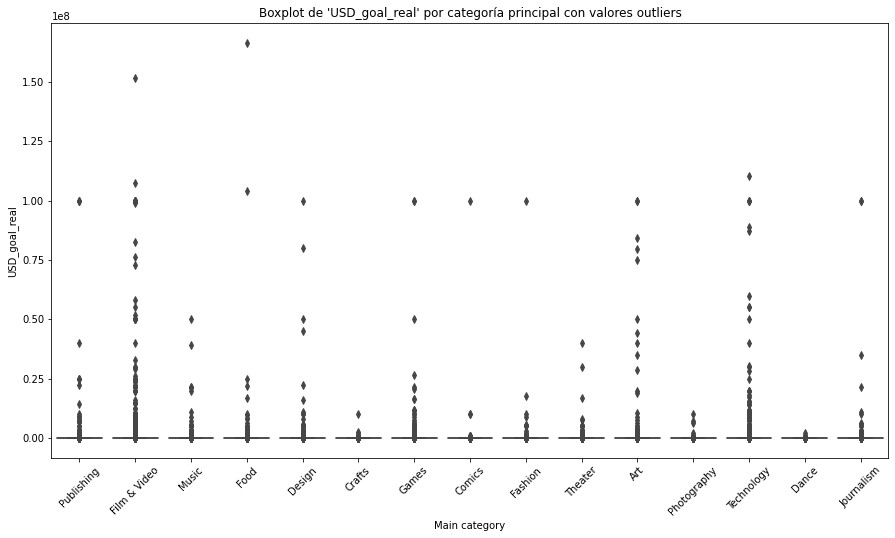

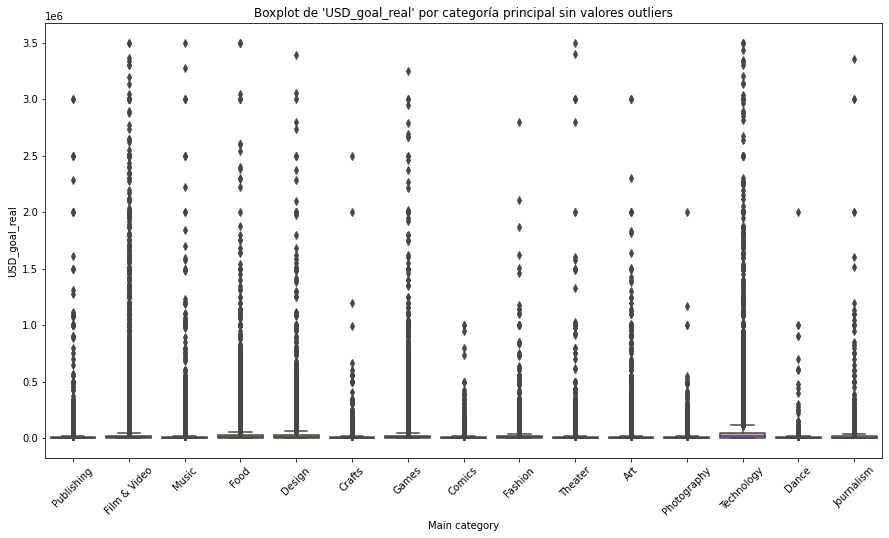

In [72]:
plt.figure(figsize=(15,8))
ax = sbn.boxplot(x='main_category',y= 'usd_goal_real', data=ks_2018)
plt.ylabel('USD_goal_real')
plt.xlabel('Main category')
plt.title("Boxplot de 'USD_goal_real' por categoría principal con valores outliers")
plt.xticks(rotation=45)

plt.figure(figsize=(15,8))
ax = sbn.boxplot(x='main_category',y= 'usd_goal_real', data=ks_2018.drop(outliers.index))
plt.ylabel('USD_goal_real')
plt.xlabel('Main category')
plt.title("Boxplot de 'USD_goal_real' por categoría principal sin valores outliers")
plt.xticks(rotation=45)